In [1]:
import os
import sys
# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve
from multipy.fwer import sidak, hochberg
import random

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances, plot_volcano
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, split_data, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing, get_top_changed_clonotypes
from utils.clustering_utils import seqs2hamming
from utils.weblogo_utils import create_web_logo
from source.alpha_beta_paired_clones_search import make_metaclone_cm

import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

/home/evlasova/tcr-covid-classifier


<module 'utils.viz_utils' from '/home/evlasova/tcr-covid-classifier/utils/viz_utils.py'>

# COVID-19 associated VDJDb clones selection 

In [7]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [8]:
covid_vdjdb = vdjdb[vdjdb['antigen.species'] == 'SARS-CoV-2']

In [9]:
covid_vdjdb.head()

,complex.id,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,...,antigen.species,reference.id,method,meta,cdr3fix,vdjdb.score,web.method,web.method.seq,web.cdr3fix.nc,web.cdr3fix.unmp
419,0,TRB,CASSQTTKDEQYF,TRBV4-2*01,TRBJ2-7*01,HomoSapiens,HLA-A*03:01,B2M,MHCI,KTFPPTEPK,...,SARS-CoV-2,https://github.com/antigenomics/vdjdb-db/issue...,"{""frequency"": ""0.199348284"", ""identification"":...","{""cell.subset"": ""CD8+ expansion"", ""clone.id"": ...","{""cdr3"": ""CASSQTTKDEQYF"", ""cdr3_old"": ""CASSQTT...",1,sort,amplicon,no,no
420,0,TRB,CASSQGQKDEQYF,TRBV4-2*01,TRBJ2-7*01,HomoSapiens,HLA-A*03:01,B2M,MHCI,KTFPPTEPK,...,SARS-CoV-2,https://github.com/antigenomics/vdjdb-db/issue...,"{""frequency"": ""0.156986774"", ""identification"":...","{""cell.subset"": ""CD8+ expansion"", ""clone.id"": ...","{""cdr3"": ""CASSQGQKDEQYF"", ""cdr3_old"": ""CASSQGQ...",1,sort,amplicon,no,no
421,0,TRB,CASSQFTGRKEKLFF,TRBV16*01,TRBJ1-4*01,HomoSapiens,HLA-A*03:01,B2M,MHCI,KTFPPTEPK,...,SARS-CoV-2,https://github.com/antigenomics/vdjdb-db/issue...,"{""frequency"": ""0.081656124"", ""identification"":...","{""cell.subset"": ""CD8+ expansion"", ""clone.id"": ...","{""cdr3"": ""CASSQFTGRKEKLFF"", ""cdr3_old"": ""CASSQ...",1,sort,amplicon,no,no
422,0,TRB,CASSLTSGGPTSDTQYF,TRBV5-1*01,TRBJ2-3*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,LLYDANYFL,...,SARS-CoV-2,https://github.com/antigenomics/vdjdb-db/issue...,"{""frequency"": ""0.058802045"", ""identification"":...","{""cell.subset"": ""CD8+ expansion"", ""clone.id"": ...","{""cdr3"": ""CASSLTSGGPTSDTQYF"", ""cdr3_old"": ""CAS...",1,sort,amplicon,no,no
423,0,TRB,CASTTPVTERYNEQFF,TRBV28*01,TRBJ2-1*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,LLYDANYFL,...,SARS-CoV-2,https://github.com/antigenomics/vdjdb-db/issue...,"{""frequency"": ""0.092037984"", ""identification"":...","{""cell.subset"": ""CD8+ expansion"", ""clone.id"": ...","{""cdr3"": ""CASTTPVTERYNEQFF"", ""cdr3_old"": ""CAST...",1,sort,amplicon,no,no


In [10]:
covid_vdjdb[covid_vdjdb.gene == 'TRB']['mhc.a'].apply(lambda x: x.split('-')[-1].split(':')[0]).value_counts()

A*02       2329
A*01        681
B*07        591
A*24        259
B*15        101
DRB1*04      32
B*44         19
DRB1*03      16
DRA*01       13
A*03         10
DRB1*11      10
DQA1*01       5
A*11          2
Name: mhc.a, dtype: int64

In [11]:
covid_vdjdb['mhc.b'].apply(lambda x: x.split('-')[-1].split(':')[0]).value_counts()

B2M        7135
DRA*01      116
DRB1*15      13
DQB1*06      10
Name: mhc.b, dtype: int64

In [12]:
vdjdb_runs = set()
for allele in covid_vdjdb['mhc.a'].apply(lambda x: x.split('-')[-1].split(':')[0]).unique():
    if len(covid_vdjdb[covid_vdjdb['mhc.a'].str.contains(allele)]) > 100:
        try:
            vdjdb_runs = vdjdb_runs.union(set(prepare_run_column(pd.read_csv(f'data/hla_desc/fmba_desc_hla_{allele}.csv')).run))
        except Exception as e:
            print(f'error processing {allele}')
    else:
        print(f'{allele} is too rare')

A*03 is too rare
DRA*01 is too rare
B*44 is too rare
DRB1*03 is too rare
DRB1*04 is too rare
DRB1*11 is too rare
DQA1*01 is too rare
A*11 is too rare


In [13]:
for allele in covid_vdjdb['mhc.b'].apply(lambda x: x.split('-')[-1].split(':')[0]).unique():
    if len(covid_vdjdb[covid_vdjdb['mhc.b'].str.contains(allele)]) > 100:
        try:
            vdjdb_runs = vdjdb_runs.union(set(prepare_run_column(pd.read_csv(f'data/hla_desc/fmba_desc_hla_{allele}.csv')).run))
        except Exception as e:
            print(f'error processing {allele}')
    else:
        print(f'{allele} is too rare')

error processing B2M
DRB1*15 is too rare
DRA*01 is too rare
DQB1*06 is too rare


In [14]:
len(vdjdb_runs)

805

In [15]:
covid_vdjdb['vdjdb.score'].value_counts()

0    6725
1     307
2     234
3       8
Name: vdjdb.score, dtype: int64

In [16]:
desc = pd.read_csv('data/desc_fmba_not_nan_hla.csv').drop(columns=['Unnamed: 0'])
desc['covid'] = desc.COVID_status.apply(lambda x: 'covid' if x == 'COVID' else 'healthy')
desc

,run,reads,clonotypes,singletons,doubletons,file.id,sequencingDate,folder,R1,R2,...,HLA-DRB1.1,HLA-DRB1.2,id,subsequent_sequencing,HLA-DRB4.1,HLA-DRB3.1,HLA-DRB5.1,gene,is.bad.reseq,covid
0,020000010808_S3_L001.clonotypes.TRB.txt,623811,4324,491,263,020000010808_S3_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000010808_S3_L001_R1_001.fastq.gz,020000010808_S3_L001_R2_001.fastq.gz,...,DRB1*11:04,DRB1*16:01,20000010,NaN,NaN,NaN,NaN,TRB,NaN,covid
1,020000110808_S14_L001.clonotypes.TRB.txt,13119545,13264,573,219,020000110808_S14_L001,2020 09 05,2020/09_FMBA_NovaSeq_DNA,020000110808_S14_L001_R1_001.fastq.gz,020000110808_S14_L001_R2_001.fastq.gz,...,DRB1*01:01,DRB1*15:01,20000110,NaN,NaN,NaN,NaN,TRB,NaN,covid
2,020000190808_S27_L001.clonotypes.TRB.txt,6942203,16977,1198,550,020000190808_S27_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000190808_S27_L001_R1_001.fastq.gz,020000190808_S27_L001_R2_001.fastq.gz,...,DRB1*07:01,DRB1*15:02,20000190,NaN,NaN,NaN,NaN,TRB,NaN,covid
3,020000200808_S181_L002.clonotypes.TRB.txt,6583555,14220,916,420,020000200808_S181_L002,2020 10 19,2020/10_FMBA_NovaSeq5,020000200808_S181_L002_R1_001.fastq.gz,020000200808_S181_L002_R2_001.fastq.gz,...,DRB1*01:01,DRB1*04:04,20000200,NaN,NaN,NaN,NaN,TRB,NaN,healthy
4,020000280808_S59_L001.clonotypes.TRB.txt,2005779,6144,477,260,020000280808_S59_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000280808_S59_L001_R1_001.fastq.gz,020000280808_S59_L001_R2_001.fastq.gz,...,DRB1*01:03,DRB1*13:03,20000280,NaN,NaN,NaN,NaN,TRB,NaN,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,780008510808_S152_L002.clonotypes.TRB.txt,125864,7215,1173,793,780008510808_S152_L002,2020 09 27,2020/09_FMBA_NovaSeq3_DNA,780008510808_S152_L002_R1_001.fastq.gz,780008510808_S152_L002_R2_001.fastq.gz,...,DRB1*07:01,DRB1*15:01,780008510,NaN,NaN,NaN,NaN,TRB,NaN,covid
952,780008550808_S150_L002.clonotypes.TRB.txt,3070841,8864,398,150,780008550808_S150_L002,2020 09 27,2020/09_FMBA_NovaSeq3_DNA,780008550808_S150_L002_R1_001.fastq.gz,780008550808_S150_L002_R2_001.fastq.gz,...,DRB1*04:01,DRB1*15:01,780008550,NaN,NaN,NaN,NaN,TRB,NaN,covid
953,910000140808_S123_L002.clonotypes.TRB.txt,3095012,27443,1318,643,910000140808_S123_L002,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,910000140808_S123_L002_R1_001.fastq.gz,910000140808_S123_L002_R2_001.fastq.gz,...,DRB1*03:01,DRB1*07:01,910000140,NaN,NaN,NaN,NaN,TRB,NaN,covid
954,910000320808_S121_L002.clonotypes.TRB.txt,203560,11451,2013,1299,910000320808_S121_L002,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,910000320808_S121_L002_R1_001.fastq.gz,910000320808_S121_L002_R2_001.fastq.gz,...,DRB1*01:02,DRB1*07:01,910000320,NaN,NaN,NaN,NaN,TRB,NaN,covid


In [17]:
train_runs = prepare_run_column(desc[~desc.folder.str.lower().str.contains('novaseq6')]).run
test_runs = prepare_run_column(desc[desc.folder.str.lower().str.contains('novaseq6')]).run

train_runs = train_runs[train_runs.isin(vdjdb_runs)]
test_runs = test_runs[test_runs.isin(vdjdb_runs)]

In [18]:
train_runs.shape

(712,)

In [19]:
test_runs.shape

(93,)

# VDJDb clones analysis 

In [20]:
beta_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_vdjdb.csv').drop(columns=['Unnamed: 0'])

In [21]:
beta_cm

,CASSQTTKDEQYF,CASSQGQKDEQYF,CASSQFTGRKEKLFF,CASSLTSGGPTSDTQYF,CASTTPVTERYNEQFF,CASTTSRGAISTDTQYF,CASSQGTGGANEQYF,CASSLAGSTEAFF,CASSLAGSTEAFF.1,CASSLTSGGPVTDTQYF,...,CASSLGETIYGYTF,CSARTISQGAHYEQYF,CAGKSTGELFF,CASSWNGLAGDEQFF,CASSALVAFSTDTQYF,CASSSLAGEVNEQFF,CASSSYTQRGLDYTGELFF,CSVEDPMGVGTEAFF,CASSQDYWGGGADTQYF,run
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,440001090808_S88_L001.clonotypes.TRB.txt
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,020000010808_S3_L001.clonotypes.TRB.txt
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,540000140808_S36_L001.clonotypes.TRB.txt
3,0,0,0,0,0,0,0,3,3,0,...,0,0,0,0,0,0,0,0,0,050000990808_S40_L001.clonotypes.TRB.txt
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,050001920808_S78_L001.clonotypes.TRB.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,0,0,0,0,0,0,0,4,4,0,...,0,0,0,0,0,0,0,0,0,210002410808_S177_L002.clonotypes.TRB.txt
952,0,0,0,0,0,0,0,2,2,0,...,0,0,0,0,0,0,0,0,0,210002440808_S113_L002.clonotypes.TRB.txt
953,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,640002910808_S86_L001.clonotypes.TRB.txt
954,0,0,0,0,0,0,0,5,5,0,...,0,0,0,0,0,0,0,0,0,640002920808_S23_L001.clonotypes.TRB.txt


In [22]:
beta_cm.columns = pd.Series(beta_cm.columns).apply(lambda x: x.split('.')[0])

In [23]:
beta_cm = beta_cm.loc[:,~beta_cm.columns.duplicated()].copy()

In [24]:
beta_vdjdb_clones = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_vdjdb.csv').drop(columns=['Unnamed: 0', 'run']).columns

In [25]:
beta_cm = prepare_run_column(beta_cm)

updated version
0.04469695700550463 22.910332608594672 0.9845229175541274 2.424392499380616e-190 0.0005042257967181546
0.04541921539949675 31.62974646161615 0.9750954143315671 0.0 0.00043970021252758733


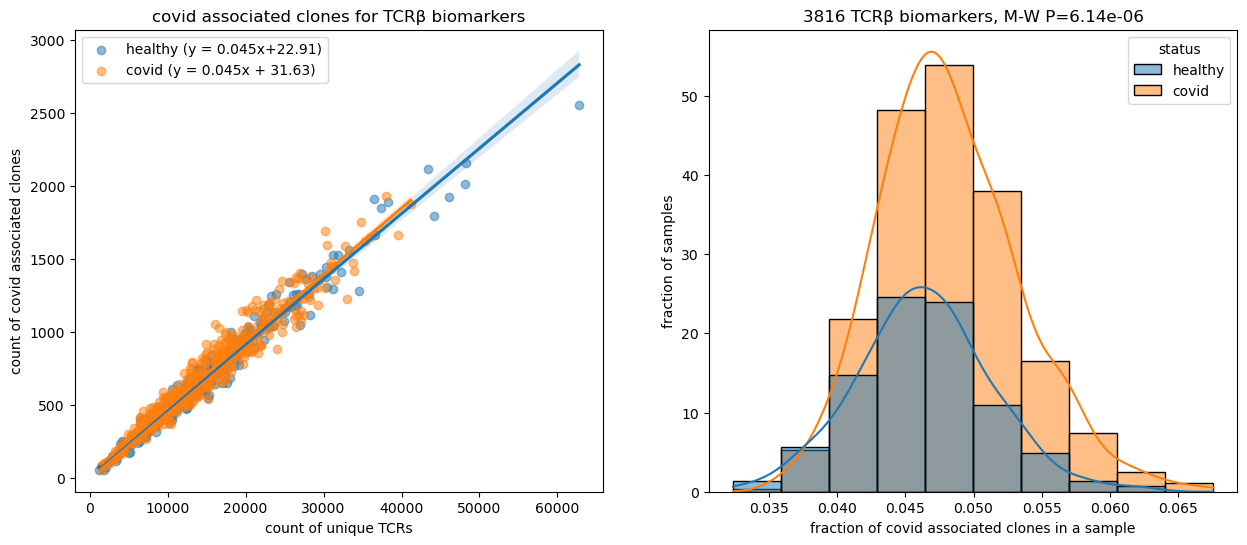

In [26]:
significant_clones_distribution(significant_clonotype_matrix=beta_cm[beta_cm.run.isin(vdjdb_runs)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',)

In [27]:
beta_cm[beta_cm.run.isin(train_runs)]

,CASSQTTKDEQYF,CASSQGQKDEQYF,CASSQFTGRKEKLFF,CASSLTSGGPTSDTQYF,CASTTPVTERYNEQFF,CASTTSRGAISTDTQYF,CASSQGTGGANEQYF,CASSLAGSTEAFF,CASSLTSGGPVTDTQYF,CASSLGGTEAFF,...,CASSLGETIYGYTF,CSARTISQGAHYEQYF,CAGKSTGELFF,CASSWNGLAGDEQFF,CASSALVAFSTDTQYF,CASSSLAGEVNEQFF,CASSSYTQRGLDYTGELFF,CSVEDPMGVGTEAFF,CASSQDYWGGGADTQYF,run
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,440001090808_S88_L001
1,0,0,0,0,0,0,0,1,0,4,...,0,0,0,0,0,0,0,0,0,020000010808_S3_L001
2,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,540000140808_S36_L001
3,0,0,0,0,0,0,0,3,0,3,...,0,0,0,0,0,0,0,0,0,050000990808_S40_L001
5,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,340002510808_S180_L002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,0,0,0,0,0,0,0,2,0,12,...,0,0,0,0,0,0,0,0,0,550001670808_S187_L002
951,0,0,0,0,0,0,0,4,0,16,...,0,0,0,0,0,0,0,0,0,210002410808_S177_L002
952,0,0,0,0,0,0,0,2,0,6,...,0,0,0,0,0,0,0,0,0,210002440808_S113_L002
954,0,0,0,0,0,0,0,5,0,3,...,0,0,0,0,0,0,0,0,0,640002920808_S23_L001


In [29]:
fold_change_vdjdb_beta = get_top_changed_clonotypes(clonotype_matrix=beta_cm[beta_cm.run.isin(train_runs)],
                           desc=desc, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_fmba_TRB_vdjdb.csv').drop(columns=['Unnamed: 0']), 
                           run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'),
                           healthy_col='covid', 
                           healthy_label='healthy')
fold_change_vdjdb_beta.dropna()

FileNotFoundError: [Errno 2] No such file or directory: 'data/covid_significant_clone_pvals_fmba_TRB_vdjdb.csv'

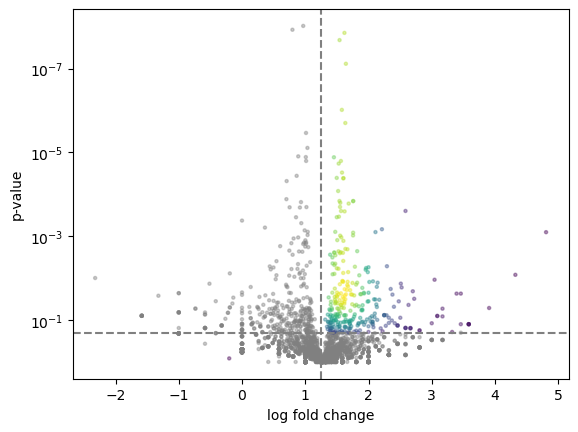

In [278]:
plot_volcano(fold_change_vdjdb_beta, pval_threshold=0.2, fold_change_threshold=1.25)

In [29]:
beta_cm_selected = beta_cm[['run'] + list(
    fold_change_vdjdb_beta[(fold_change_vdjdb_beta.log_fold_change > 1.25) & (fold_change_vdjdb_beta.pval < 0.2)].clone)]

updated version
0.011790114115594372 54.51140948813736 0.8801446540872627 2.1030148298455848e-21 0.0008141855166977041
0.01719789039094445 23.713922301914266 0.7701047572307632 1.5740070680579555e-11 0.0019948248023595955


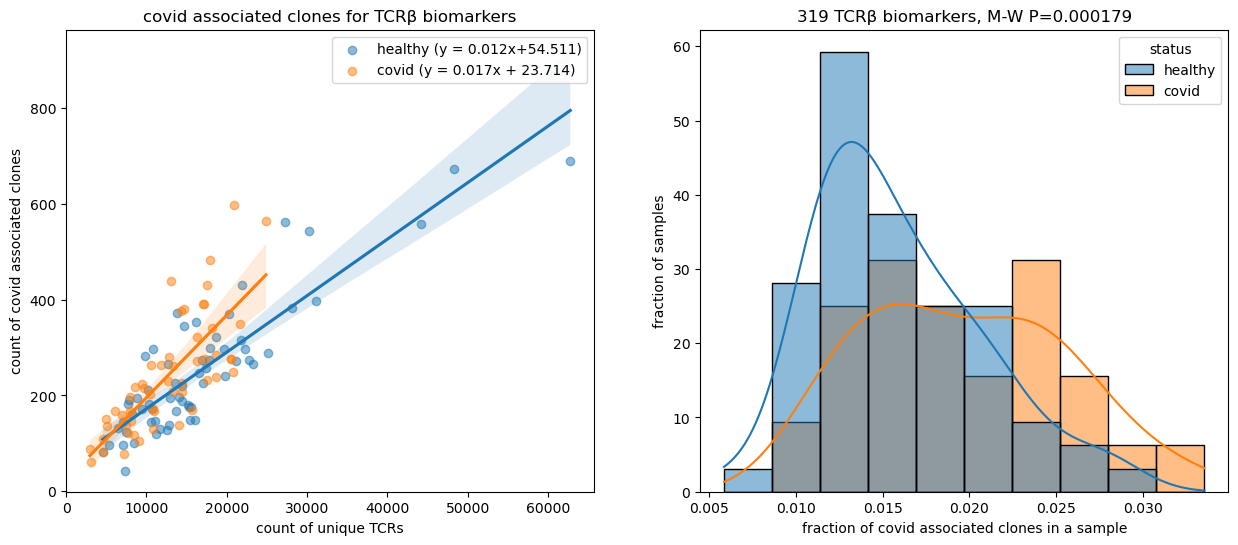

In [30]:
significant_clones_distribution(significant_clonotype_matrix=beta_cm_selected[beta_cm_selected.run.isin(test_runs)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',)

In [31]:
beta_covid_vdjdb = vdjdb[(vdjdb['antigen.species'] == 'SARS-CoV-2') & (vdjdb.gene == 'TRB')]\
                        [['cdr3', 'antigen.epitope']].rename(columns={'antigen.epitope': 'cluster'})
beta_covid_vdjdb

,cdr3,cluster
419,CASSQTTKDEQYF,KTFPPTEPK
420,CASSQGQKDEQYF,KTFPPTEPK
421,CASSQFTGRKEKLFF,KTFPPTEPK
422,CASSLTSGGPTSDTQYF,LLYDANYFL
423,CASTTPVTERYNEQFF,LLYDANYFL
...,...,...
89069,CASSALVAFSTDTQYF,QYIKWPWYI
89071,CASSSLAGEVNEQFF,QYIKWPWYI
89073,CASSSYTQRGLDYTGELFF,QYIKWPWYI
89074,CSVEDPMGVGTEAFF,QYIKWPWYI


In [32]:
pvals_data = pd.read_csv('data/covid_significant_clone_pvals_fmba_TRB_vdjdb.csv').drop(columns=['Unnamed: 0']).rename(columns={'clone': 'cdr3'})

In [33]:
pvals_data

,cdr3,pval
0,CASSQTTKDEQYF,0.560373
1,CASSQGQKDEQYF,0.423997
2,CASSQFTGRKEKLFF,1.000000
3,CASSLTSGGPTSDTQYF,0.294027
4,CASTTPVTERYNEQFF,1.000000
...,...,...
3811,CASSALVAFSTDTQYF,1.000000
3812,CASSSLAGEVNEQFF,0.675873
3813,CASSSYTQRGLDYTGELFF,1.000000
3814,CSVEDPMGVGTEAFF,1.000000


In [34]:
cluster_pvals = beta_covid_vdjdb.merge(pvals_data).groupby(by='cluster', as_index=False).mean().rename(columns={'cluster': 'clone'})
cluster_pvals.clone = 'cluster_' + cluster_pvals.clone
cluster_pvals

,clone,pval
0,cluster_AALALLLLDRLNQLE,0.678813
1,cluster_AEVQIDRLI,0.404574
2,cluster_AFLLFLVLI,0.925074
3,cluster_AHIQWMVMF,1.000000
4,cluster_AIFYLITPV,0.707542
...,...,...
661,cluster_YVYSRVKNL,1.000000
662,cluster_YYKKDNSYF,1.000000
663,cluster_YYQLYSTQL,1.000000
664,cluster_YYRYNLPTM,0.756292


In [35]:
metaclone_beta_cm = make_metaclone_cm(beta_cm, beta_covid_vdjdb[beta_covid_vdjdb.cdr3.isin(beta_cm.columns)])

In [36]:
metaclone_beta_cm.to_csv('data/clone_matrix_covid_fmba_TRB_metaclone_vdjdb.csv')

In [37]:
metaclone_beta_cm

,run,cluster_KTFPPTEPK,cluster_LLYDANYFL,cluster_ALSKGVHFV,cluster_LLLDRLNQL,cluster_ALWEIQQVV,cluster_RLQSLQTYV,cluster_YLQPRTFLL,cluster_RLITGRLQSL,cluster_KQIYKTPPI,...,cluster_STECSNLLL,cluster_VFLVLWPLV,cluster_KWPWYIWLG,cluster_VYSTGSNVF,cluster_QPYRVVVLS,cluster_RVVVLSFEL,cluster_FSNVTWFHA,cluster_WTAGAAAYY,cluster_TSNEVAVLY,cluster_YYTSNPTTF
0,440001090808_S88_L001,0,10,0,0,1,4,21,0,0,...,0,0,0,0,0,0,0,0,0,0
1,020000010808_S3_L001,0,43,6,3,0,8,35,1,0,...,0,0,0,0,0,0,0,0,0,0
2,540000140808_S36_L001,0,68,1,2,3,4,41,0,0,...,0,1,0,0,0,1,0,0,0,0
3,050000990808_S40_L001,0,44,0,3,3,4,57,1,0,...,0,4,0,0,0,0,0,0,0,0
4,050001920808_S78_L001,1,47,5,1,2,11,71,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,210002410808_S177_L002,0,225,13,6,9,32,369,3,0,...,0,4,0,0,0,0,0,0,0,0
952,210002440808_S113_L002,0,85,5,1,10,9,170,4,0,...,0,0,0,0,0,0,0,0,0,0
953,640002910808_S86_L001,1,104,11,1,12,20,229,3,1,...,0,1,1,1,0,0,0,0,0,0
954,640002920808_S23_L001,0,68,1,4,10,7,111,2,0,...,0,0,1,1,0,0,0,0,0,0


In [38]:
fold_change_vdjdb_beta = get_top_changed_clonotypes(clonotype_matrix=metaclone_beta_cm[metaclone_beta_cm.run.isin(train_runs)],
                           desc=desc, 
                           pvals=cluster_pvals, 
                           log_fold_change_threshold=2, 
                           logp_threshold=1,
                           healthy_col='covid', 
                           healthy_label='healthy')
fold_change_vdjdb_beta.dropna()

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,cluster_AALALLLLDRLNQLE,0.678813,518,1373,2.650579,1.406308
1,cluster_AEVQIDRLI,0.404574,573,1505,2.626527,1.393156
2,cluster_AFLLFLVLI,0.925074,40,95,2.375000,1.247928
3,cluster_AHIQWMVMF,1.000000,0,2,inf,inf
4,cluster_AIFYLITPV,0.707542,138,329,2.384058,1.253419
...,...,...,...,...,...,...
660,cluster_YVWKSYVHV,0.747325,71,188,2.647887,1.404842
661,cluster_YVYSRVKNL,1.000000,20,48,2.400000,1.263034
663,cluster_YYQLYSTQL,1.000000,0,1,inf,inf
664,cluster_YYRYNLPTM,0.756292,60,139,2.316667,1.212050


In [39]:
data_with_epi_allele = fold_change_vdjdb_beta.dropna().sort_values(by='log_fold_change')
data_with_epi_allele.clone = data_with_epi_allele.clone.apply(lambda x: x.split('_')[1])
data_with_epi_allele = data_with_epi_allele.rename(columns={'clone': 'antigen.epitope'}).merge(vdjdb[['antigen.epitope', 'mhc.a']])
data_with_epi_allele[data_with_epi_allele.log_fold_change > 1].drop_duplicates()['mhc.a'].value_counts()

HLA-A*02:01       279
HLA-B*07:02        67
HLA-A*01:01        63
HLA-A*24:02        35
HLA-B*44:02         3
HLA-DRB1*03:01      3
HLA-A*02            3
HLA-DRB1*04:05      2
HLA-A*02:01:48      2
HLA-B*15:01         2
HLA-A*24:01         2
HLA-A*03:01         1
HLA-A*11:01         1
HLA-DQA1*01:02      1
HLA-DRA*01:01       1
Name: mhc.a, dtype: int64

In [40]:
data_with_epi_allele[data_with_epi_allele.log_fold_change < 100]

,antigen.epitope,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change,mhc.a
0,TLIGDCATV,0.086452,2,0,0.000000,-inf,HLA-A*02:01
1,TLIGDCATV,0.086452,2,0,0.000000,-inf,HLA-A*02:01
2,WLTYTGAIK,0.294027,1,0,0.000000,-inf,HLA-A*02:01
3,WLTYTGAIK,0.294027,1,0,0.000000,-inf,HLA-A*02:01
4,YLAVFDKNL,0.294027,1,0,0.000000,-inf,HLA-A*02:01
...,...,...,...,...,...,...,...
7000,FLWLLWPVT,0.134922,3,26,8.666667,3.115477,HLA-A*02:01
7001,FLWLLWPVT,0.134922,3,26,8.666667,3.115477,HLA-A*02:01
7002,KPADNSLKI,0.649523,1,9,9.000000,3.169925,HLA-B*07:02
7003,KPADNSLKI,0.649523,1,9,9.000000,3.169925,HLA-B*07:02


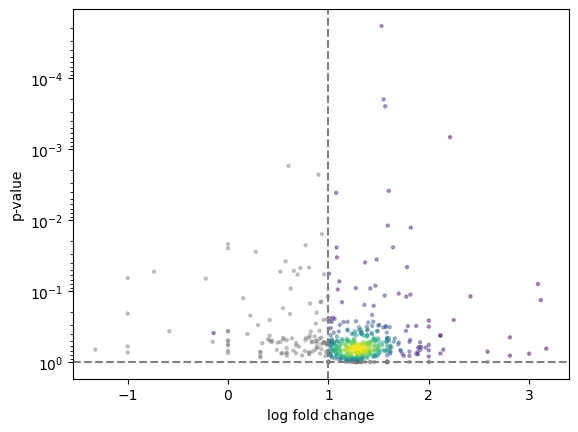

In [41]:
plot_volcano(fold_change_vdjdb_beta, pval_threshold=1, fold_change_threshold=1)

In [42]:
beta_cm_selected_meta = metaclone_beta_cm[['run'] + list(
    fold_change_vdjdb_beta[(fold_change_vdjdb_beta.log_fold_change > 1) & (fold_change_vdjdb_beta.pval <= 1)].clone)]

In [43]:
beta_cm_selected_meta

,run,cluster_AALALLLLDRLNQLE,cluster_AEVQIDRLI,cluster_AFLLFLVLI,cluster_AHIQWMVMF,cluster_AIFYLITPV,cluster_AIILASFSA,cluster_AIKLDDKDP,cluster_ALNLGETFV,cluster_ALNNIINNA,...,cluster_YTPSKLIEY,cluster_YTVELGTEV,cluster_YVDNSSLTI,cluster_YVFCTVNAL,cluster_YVVDDPCPI,cluster_YVWKSYVHV,cluster_YVYSRVKNL,cluster_YYQLYSTQL,cluster_YYRYNLPTM,cluster_YYTSNPTTF
0,440001090808_S88_L001,0,1,0,0,0,0,0,1,0,...,0,0,5,0,0,0,0,0,0,0
1,020000010808_S3_L001,1,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
2,540000140808_S36_L001,1,1,0,0,3,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,050000990808_S40_L001,1,4,0,0,0,0,0,0,0,...,0,0,3,1,0,0,0,0,0,0
4,050001920808_S78_L001,3,2,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,210002410808_S177_L002,5,3,0,0,0,0,0,2,0,...,0,1,6,2,0,0,0,0,0,0
952,210002440808_S113_L002,3,2,0,0,0,0,0,1,0,...,0,0,6,1,0,2,0,0,0,0
953,640002910808_S86_L001,7,3,0,0,3,0,0,6,0,...,0,0,7,2,2,1,0,0,0,0
954,640002920808_S23_L001,2,1,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0


In [44]:
metaclone_beta_cm['cluster_AFLLFLVLI']

0      0
1      0
2      0
3      0
4      0
      ..
951    0
952    0
953    0
954    0
955    1
Name: cluster_AFLLFLVLI, Length: 956, dtype: int64

In [45]:
alpha_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_vdjdb.csv').drop(columns=['Unnamed: 0'])
alpha_vdjdb_clones = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_vdjdb.csv').drop(columns=['Unnamed: 0', 'run']).columns
alpha_covid_vdjdb = vdjdb[(vdjdb['antigen.species'] == 'SARS-CoV-2') & (vdjdb.gene == 'TRA')]\
                        [['cdr3', 'antigen.epitope']].rename(columns={'antigen.epitope': 'cluster'})

In [46]:
alpha_cm = prepare_run_column(alpha_cm)

updated version
0.2657275721156878 1477.4299989368992 0.932136961308576 7.651201161871319e-112 0.0065417331163872714
0.24775197518691536 2202.8873728023073 0.9040275526907016 6.865645167179226e-206 0.004986270315882152


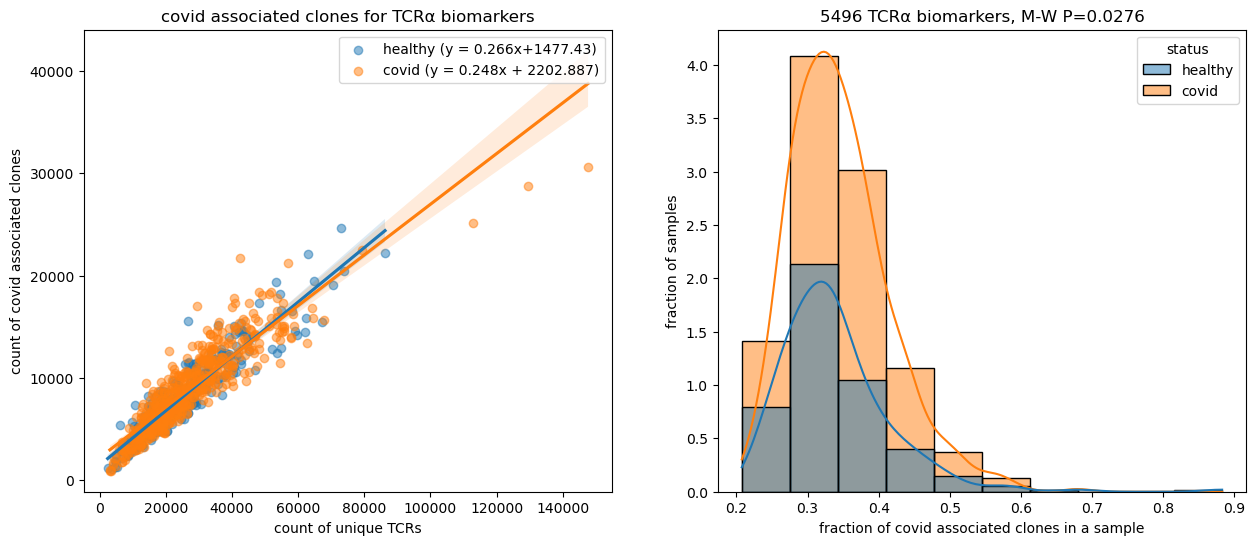

In [47]:
significant_clones_distribution(significant_clonotype_matrix=alpha_cm[alpha_cm.run.isin(vdjdb_runs)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'), 
                                desc=desc, 
                                data_description='TCRα biomarkers',
                                by='covid',)

In [48]:
fold_change_vdjdb_alpha = get_top_changed_clonotypes(clonotype_matrix=alpha_cm[alpha_cm.run.isin(train_runs)],
                           desc=desc, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_fmba_TRA_vdjdb.csv').drop(columns=['Unnamed: 0']), 
                           log_fold_change_threshold=2, 
                           logp_threshold=1,
                           healthy_col='covid', 
                           healthy_label='healthy')
fold_change_vdjdb_alpha.dropna()

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,CALSGFNNAGNMLTF,0.366436,99,299,3.020202,1.594645
1,CAVNRDDKIIF,1.000000,4,11,2.750000,1.459432
2,CVVNRNNDMRF,0.361683,330,952,2.884848,1.528496
3,CVVNLNTDKLIF,0.156276,158,490,3.101266,1.632857
4,CVVNSGNDMRF,0.463619,71,215,3.028169,1.598446
...,...,...,...,...,...,...
2902,CAVYNQGGKLIF,0.178099,2256,5914,2.621454,1.390367
2903,CAVRALYNFNKFYF,0.000224,41,203,4.951220,2.307784
2904,CAVESYNTDKLIF,0.000377,714,2255,3.158263,1.659131
2905,CLVGENSGGFKTIF,0.068307,21,34,1.619048,0.695145


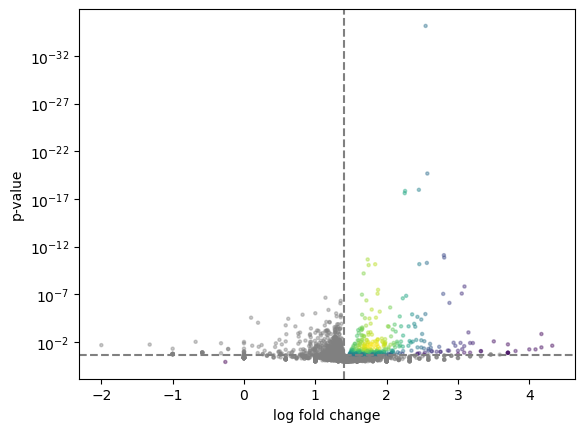

In [49]:
plot_volcano(fold_change_vdjdb_alpha, pval_threshold=0.2, fold_change_threshold=1.4)

In [50]:
alpha_cm_selected = alpha_cm[['run'] + list(
    fold_change_vdjdb_alpha[(fold_change_vdjdb_alpha.log_fold_change > 1.4) & (fold_change_vdjdb_alpha.pval < 0.2)].clone)]

updated version
0.011686134670982642 45.72931240124069 0.9392239039774364 5.132309936640028e-30 0.0005469116944305909
0.015145152778381812 -9.439522314191777 0.9684869366200776 1.8675950064052501e-32 0.0005453890114437759


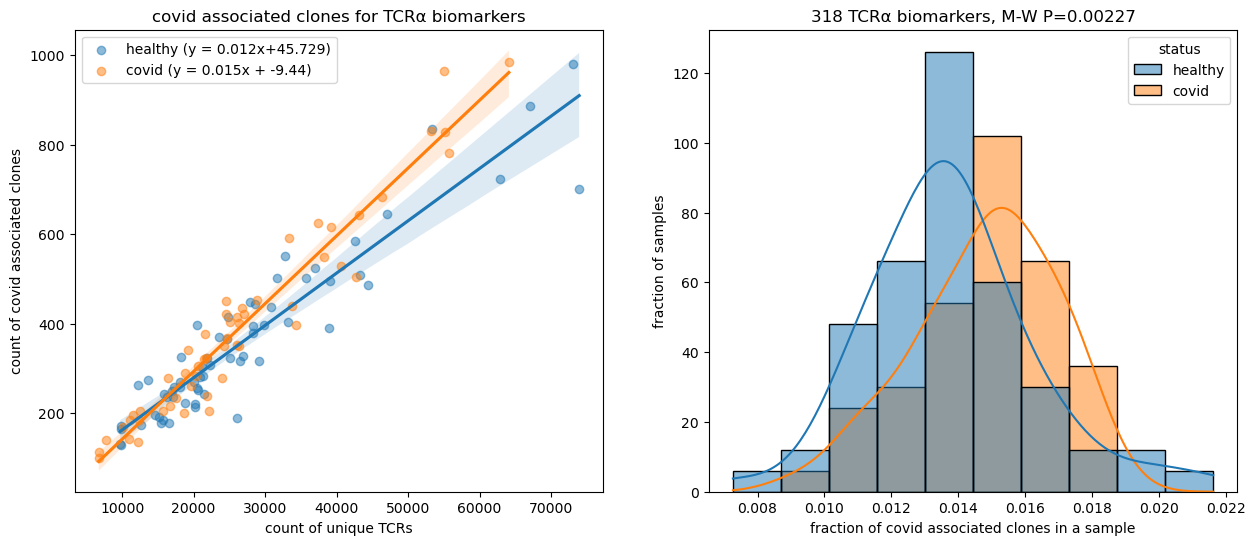

In [51]:
significant_clones_distribution(significant_clonotype_matrix=alpha_cm_selected[alpha_cm_selected.run.isin(test_runs)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'), 
                                desc=desc, 
                                data_description='TCRα biomarkers',
                                by='covid',)

In [52]:
metaclone_alpha_cm = make_metaclone_cm(alpha_cm_selected, alpha_covid_vdjdb[alpha_covid_vdjdb.cdr3.isin(alpha_cm_selected.columns)])
metaclone_alpha_cm.to_csv('data/clone_matrix_covid_fmba_TRA_metaclone_vdjdb.csv')

# Training separate α/β classifiers

In [201]:
runs = prepare_run_column(pd.read_csv('data/standardized_usage_matrix_fmba_TRA.csv'))

In [205]:
runs = runs[runs.run.isin(vdjdb_runs)]

In [208]:
data_beta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_vdjdb.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     make_all_features_bool=False,
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',).loc[runs.index]

In [209]:
data_beta

,CASSQTTKDEQYF,CASSQGQKDEQYF,CASSQFTGRKEKLFF,CASSLTSGGPTSDTQYF,CASSQGTGGANEQYF,CASSLAGSTEAFF,CASSLAGSTEAFF.1,CASSLTSGGPVTDTQYF,CASSLGGTEAFF,CASSLGGTEAFF.1,...,DRB1*15,DRB1*13,DRB1*04,DRB1*09,DRB1*10,DRB1*14,DRB1*12,DRB1*16,covid,is_test_run
0,-0.062774,-0.113068,-0.044177,-0.032359,-0.11165,0.744108,0.744108,-0.076784,2.162569,2.162569,...,False,False,False,False,False,False,False,True,1,False
1,-0.062774,-0.113068,-0.044177,-0.032359,-0.11165,-1.080500,-1.080500,-0.076784,-0.769355,-0.769355,...,True,False,False,False,False,False,False,False,1,False
2,-0.062774,-0.113068,-0.044177,-0.032359,-0.11165,-0.535870,-0.535870,-0.076784,2.045670,2.045670,...,False,False,True,False,False,False,False,False,0,False
3,-0.062774,-0.113068,-0.044177,-0.032359,-0.11165,-1.080500,-1.080500,-0.076784,0.961895,0.961895,...,False,True,False,False,False,False,False,False,1,False
5,-0.062774,-0.113068,-0.044177,-0.032359,-0.11165,0.081483,0.081483,-0.076784,1.365279,1.365279,...,False,False,False,False,False,False,False,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,-0.062774,-0.113068,-0.044177,-0.032359,-0.11165,-1.080500,-1.080500,-0.076784,1.099898,1.099898,...,True,True,False,False,False,False,False,False,0,False
950,-0.062774,-0.113068,-0.044177,-0.032359,-0.11165,-1.080500,-1.080500,-0.076784,-1.215629,-1.215629,...,True,True,False,False,False,False,False,False,0,False
951,-0.062774,-0.113068,-0.044177,-0.032359,-0.11165,-1.080500,-1.080500,-0.076784,-1.746663,-1.746663,...,False,False,False,False,False,False,False,False,0,False
953,-0.062774,-0.113068,-0.044177,-0.032359,-0.11165,-1.080500,-1.080500,-0.076784,-0.074686,-0.074686,...,True,False,True,False,False,False,False,False,0,False


In [210]:
data_beta = data_beta[list(beta_cm_selected.columns[1:]) + ['covid', 'is_test_run']]

In [211]:
data_beta.shape

(805, 321)

In [212]:
X_train, y_train, X_test, y_test = split_data(data=data_beta, y_column='covid', by='is_test_run')
best_clfs_beta = evaluate_models(X_train, y_train, X_test, y_test, get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 5, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.67

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 150, 'model__random_state': 42}
Test f1-score for the best model 0.64

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 3, 'model__weights': 'uniform'}
Test f1-score for the best model 0.37

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.01, 'model__hidden_layer_sizes': (100, 60, 30, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 42}


In [213]:
best_clfs_beta[0]['svm'].predict(X_test)

array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1])

In [214]:
pred = pd.DataFrame({'test': y_test, 'pred':best_clfs_beta[0]['svm'].predict(X_test)})
pred['correct'] = pred.test == pred.pred

In [215]:
pred.correct.value_counts()

True     57
False    36
Name: correct, dtype: int64

In [216]:
best_clfs_beta[0]['svm'].score(X_test, y_test)

0.6129032258064516

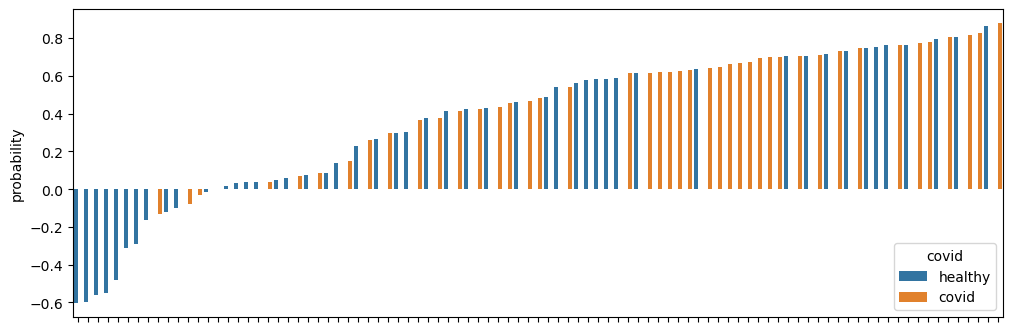

In [217]:
proba_labels = y_test.apply(lambda x: 'healthy' if x == 0 else 'covid')
probability_df = pd.DataFrame({'beta_proba': best_clfs_beta[0]['svm'].predict_proba(X_test)[::, 1], 'covid': proba_labels})
plot_waterfall_by_column(probability_df, proba_column='beta_proba', label_column='covid')

In [219]:
data_alpha = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRA_vdjdb.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',).loc[runs.index]

In [220]:
data_alpha = data_alpha[list(alpha_cm_selected.columns[1:]) + ['covid', 'is_test_run']]

In [221]:
X_train_alpha, y_train_alpha, X_test_alpha, y_test_alpha = split_data(data=data_alpha, y_column='covid', by='is_test_run')

best_clfs_alpha = evaluate_models(X_train_alpha, y_train_alpha, 
                                  X_test_alpha, y_test_alpha, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 1, 'model__kernel': 'sigmoid', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.65

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 200, 'model__random_state': 42}
Test f1-score for the best model 0.64

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 10, 'model__weights': 'distance'}
Test f1-score for the best model 0.66

Started evaluating rfc
Best params for rfc: {'model__max_depth': 3, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (150, 100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_

# Training joint αβ classifier

In [222]:
data_alpha_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRA_vdjdb.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=False,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     metadata_columns=['project', 'is_test_run']).loc[runs.index]
print('alpha ready')
data_beta_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_vdjdb.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',).loc[runs.index]

alpha ready


In [223]:
data_joint = pd.concat([data_beta_for_joint, data_alpha_for_joint.drop(columns=['covid', 'is_test_run'])], axis=1)

In [224]:
data_joint = data_joint[list(alpha_cm_selected.columns[1:]) + list(beta_cm_selected.columns[1:]) + ['covid', 'project', 'is_test_run']]

In [225]:
data_joint

,CVVNLNTDKLIF,CVVNRDTDKLIF,CVVNEDDKLIF,CVVNDNTDKLIF,CVVNREDDMRF,CVVNEGDKLIF,CVVNKEDDMRF,CVVNRGDDMRF,CVVNINTDKLIF,CALSEGYNDYKLSF,...,CASSQSGTGPYEQYF,CASSPSSREQYF,CASAALAAYNEQFF,CASSSGGYEQYF,CASSLASGYEQYF,CASSEFRSYEQYF,CASSLLGGYEQYF,covid,project,is_test_run
0,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,1.662097,-0.790430,-0.191500,1.191759,1,2020/10_FMBA_NovaSeq5,False
1,0.939237,-0.482415,-0.138679,0.907662,-0.147026,-0.254859,-0.137816,-0.336072,1.073199,3.177570,...,-0.337201,0.552687,-0.073473,-0.447294,1.033557,-0.191500,-0.871176,1,2020/10_FMBA_NovaSeq5,False
2,0.445796,0.417797,-0.138679,0.426152,-0.147026,-0.254859,-0.137816,1.128360,0.561494,-0.289647,...,-0.337201,0.743928,-0.073473,0.108845,-0.064504,-0.191500,3.439201,0,2020/10_FMBA_NovaSeq5,False
3,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,3.995063,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,0.798264,-0.790430,-0.191500,0.558153,1,2020/10_FMBA_NovaSeq5,False
5,-0.016585,-0.482415,-0.138679,-0.025050,-0.147026,1.938959,-0.137816,-0.336072,0.081999,-0.289647,...,1.840135,-0.433269,-0.073473,0.640701,-0.790430,2.070413,-0.214297,0,2020/10_FMBA_NovaSeq5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,1.581367,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,3.395732,-0.073473,1.580211,-0.790430,-0.191500,-0.871176,0,2020/10_FMBA_NovaSeq4,False
950,2.981900,-0.482415,-0.138679,1.102244,-0.147026,-0.254859,-0.137816,-0.336072,1.279982,-0.289647,...,-0.337201,-0.433269,-0.073473,0.377798,-0.790430,-0.191500,-0.871176,0,2020/10_FMBA_NovaSeq4,False
951,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,-1.150424,-0.790430,-0.191500,-0.871176,0,2020/10_FMBA_NovaSeq4,False
953,3.537104,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,-1.150424,-0.790430,-0.191500,2.658090,0,2020/10_FMBA_NovaSeq4,False


In [226]:
X_train_joint, y_train_joint, X_test_joint, y_test_joint = split_data(data=data_joint.drop(columns=['project']), y_column='covid', by='is_test_run')

best_clfs_joint = evaluate_models(X_train_joint, y_train_joint, X_test_joint, y_test_joint, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 5, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.66

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=3), 'model__n_estimators': 150, 'model__random_state': 42}
Test f1-score for the best model 0.59

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 3, 'model__weights': 'uniform'}
Test f1-score for the best model 0.38

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (100, 60, 30, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 42}

In [227]:
all_clfs = {
     'beta': best_clfs_beta,
     'alpha': best_clfs_alpha,
     'joint': best_clfs_joint
}
X_test_data={
     'beta': X_test,
     'alpha': X_test_alpha,
     'joint': X_test_joint
}
y_test_data={
     'beta': y_test,
     'alpha': y_test_alpha,
     'joint': y_test_joint
}
X_train_data={
     'beta': X_train,
     'alpha': X_train_alpha,
     'joint': X_train_joint
}
y_train_data={
     'beta': y_train,
     'alpha': y_train_alpha,
     'joint': y_train_joint
}

In [228]:
data_joint

,CVVNLNTDKLIF,CVVNRDTDKLIF,CVVNEDDKLIF,CVVNDNTDKLIF,CVVNREDDMRF,CVVNEGDKLIF,CVVNKEDDMRF,CVVNRGDDMRF,CVVNINTDKLIF,CALSEGYNDYKLSF,...,CASSQSGTGPYEQYF,CASSPSSREQYF,CASAALAAYNEQFF,CASSSGGYEQYF,CASSLASGYEQYF,CASSEFRSYEQYF,CASSLLGGYEQYF,covid,project,is_test_run
0,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,1.662097,-0.790430,-0.191500,1.191759,1,2020/10_FMBA_NovaSeq5,False
1,0.939237,-0.482415,-0.138679,0.907662,-0.147026,-0.254859,-0.137816,-0.336072,1.073199,3.177570,...,-0.337201,0.552687,-0.073473,-0.447294,1.033557,-0.191500,-0.871176,1,2020/10_FMBA_NovaSeq5,False
2,0.445796,0.417797,-0.138679,0.426152,-0.147026,-0.254859,-0.137816,1.128360,0.561494,-0.289647,...,-0.337201,0.743928,-0.073473,0.108845,-0.064504,-0.191500,3.439201,0,2020/10_FMBA_NovaSeq5,False
3,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,3.995063,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,0.798264,-0.790430,-0.191500,0.558153,1,2020/10_FMBA_NovaSeq5,False
5,-0.016585,-0.482415,-0.138679,-0.025050,-0.147026,1.938959,-0.137816,-0.336072,0.081999,-0.289647,...,1.840135,-0.433269,-0.073473,0.640701,-0.790430,2.070413,-0.214297,0,2020/10_FMBA_NovaSeq5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,1.581367,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,3.395732,-0.073473,1.580211,-0.790430,-0.191500,-0.871176,0,2020/10_FMBA_NovaSeq4,False
950,2.981900,-0.482415,-0.138679,1.102244,-0.147026,-0.254859,-0.137816,-0.336072,1.279982,-0.289647,...,-0.337201,-0.433269,-0.073473,0.377798,-0.790430,-0.191500,-0.871176,0,2020/10_FMBA_NovaSeq4,False
951,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,-1.150424,-0.790430,-0.191500,-0.871176,0,2020/10_FMBA_NovaSeq4,False
953,3.537104,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,-1.150424,-0.790430,-0.191500,2.658090,0,2020/10_FMBA_NovaSeq4,False


In [229]:
model_df = []
f1_df = []
data_type_df = []
for data_type in ['beta','alpha','joint']:
    for model in ['svm', 'ab', 'knn', 'rfc', 'mlpclassifier', 'xgboost']:
        cur_score = f1_score(y_test_data[data_type], all_clfs[data_type][0][model].predict(X_test_data[data_type]))
        model_df.append(model)
        data_type_df.append(data_type)
        f1_df.append(cur_score)
comparison_df = pd.DataFrame({'model':model_df, 'f1': f1_df, 'data_type':data_type_df})

In [230]:
comparison_df

,model,f1,data_type
0,svm,0.666667,beta
1,ab,0.637931,beta
2,knn,0.372881,beta
3,rfc,0.632353,beta
4,mlpclassifier,0.672727,beta
5,xgboost,0.660714,beta
6,svm,0.648649,alpha
7,ab,0.641509,alpha
8,knn,0.659341,alpha
9,rfc,0.632353,alpha


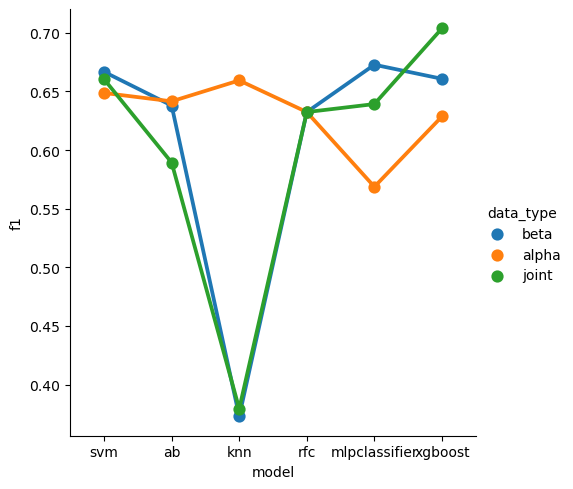

In [231]:
fig, ax = plt.subplots()
sns.catplot(data=comparison_df, x="model", y="f1", hue="data_type", kind="point", ax=ax)
plt.close(1)

<AxesSubplot:xlabel='model', ylabel='f1'>

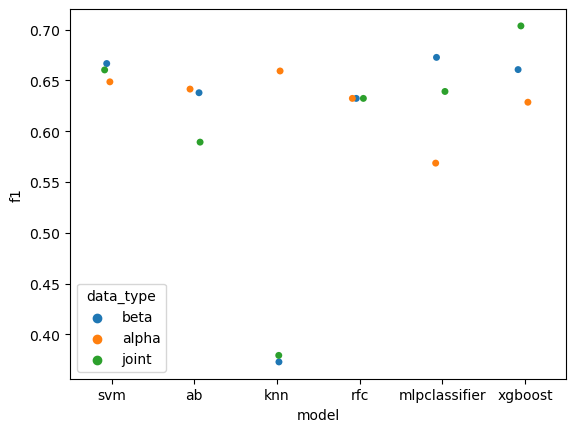

In [232]:
sns.stripplot(data=comparison_df, x="model", y="f1", hue="data_type",)

In [233]:
all_clfs['joint']

({'svm': Pipeline(steps=[('model', SVC(C=5, probability=True, random_state=42))]),
  'ab': Pipeline(steps=[('model',
                   AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                      n_estimators=150, random_state=42))]),
  'knn': Pipeline(steps=[('model', KNeighborsClassifier(leaf_size=1, n_neighbors=3))]),
  'rfc': Pipeline(steps=[('model',
                   RandomForestClassifier(max_depth=1, min_samples_leaf=8,
                                          n_estimators=50, n_jobs=-1,
                                          random_state=42))]),
  'mlpclassifier': Pipeline(steps=[('model',
                   MLPClassifier(alpha=0.001,
                                 hidden_layer_sizes=(100, 60, 30, 10),
                                 max_iter=1000, random_state=42))]),
  'xgboost': Pipeline(steps=[('model',
                   XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 co

# Making metrics dataframe

In [253]:
clf_name = []
clf_type = []
f1 = []
precision = []
recall = []
for key, clfs in all_clfs.items():
    clf_name.append(key)
    clf_type.append(clfs[2])
    best_clf = clfs[0]['xgboost']
    clf_predictions = best_clf.predict(X_test_data[key])
    f1.append(f1_score(y_test_data[key], clf_predictions))
    precision.append(precision_score(y_test_data[key], clf_predictions))
    recall.append(recall_score(y_test_data[key], clf_predictions))

In [254]:
plotting_df = pd.DataFrame({
    'classifier': clf_name, 
    'best_classifier_predictor': clf_type,
    'f1_score': f1,
    'precision_score': precision,
    'recall_score': recall
})

In [255]:
plotting_df

,classifier,best_classifier_predictor,f1_score,precision_score,recall_score
0,beta,mlpclassifier,0.660714,0.536232,0.860465
1,alpha,knn,0.628571,0.532258,0.767442
2,joint,xgboost,0.703704,0.584615,0.883721


In [256]:
plotting_df = plotting_df.applymap(lambda x: round(x, 2) if isinstance(x, float) else x)

# Preparing data for proba comparison

In [257]:
beta_predictions = all_clfs['beta'][0]['xgboost'].predict_proba(X_test_data['beta'])[::,1]
alpha_predictions = all_clfs['alpha'][0]['xgboost'].predict_proba(X_test_data['alpha'])[::,1]

proba_labels = y_test.apply(lambda x: 'healthy' if x == 0 else 'covid')
probability_df = pd.DataFrame({
    'beta_proba': beta_predictions,
    'alpha_proba': alpha_predictions,
    'covid': proba_labels
})

In [258]:
probability_df

,beta_proba,alpha_proba,covid
420,0.774548,0.999570,covid
422,0.913064,0.843258,covid
423,0.720069,0.280814,covid
425,0.750767,0.554390,healthy
426,0.402742,0.438749,healthy
...,...,...,...
531,0.738188,0.470798,healthy
532,0.996625,0.963539,healthy
533,0.596159,0.952075,healthy
534,0.438360,0.526987,healthy


# One folder out CV

In [259]:
data_joint

,CVVNLNTDKLIF,CVVNRDTDKLIF,CVVNEDDKLIF,CVVNDNTDKLIF,CVVNREDDMRF,CVVNEGDKLIF,CVVNKEDDMRF,CVVNRGDDMRF,CVVNINTDKLIF,CALSEGYNDYKLSF,...,CASSQSGTGPYEQYF,CASSPSSREQYF,CASAALAAYNEQFF,CASSSGGYEQYF,CASSLASGYEQYF,CASSEFRSYEQYF,CASSLLGGYEQYF,covid,project,is_test_run
0,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,1.662097,-0.790430,-0.191500,1.191759,1,2020/10_FMBA_NovaSeq5,False
1,0.939237,-0.482415,-0.138679,0.907662,-0.147026,-0.254859,-0.137816,-0.336072,1.073199,3.177570,...,-0.337201,0.552687,-0.073473,-0.447294,1.033557,-0.191500,-0.871176,1,2020/10_FMBA_NovaSeq5,False
2,0.445796,0.417797,-0.138679,0.426152,-0.147026,-0.254859,-0.137816,1.128360,0.561494,-0.289647,...,-0.337201,0.743928,-0.073473,0.108845,-0.064504,-0.191500,3.439201,0,2020/10_FMBA_NovaSeq5,False
3,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,3.995063,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,0.798264,-0.790430,-0.191500,0.558153,1,2020/10_FMBA_NovaSeq5,False
5,-0.016585,-0.482415,-0.138679,-0.025050,-0.147026,1.938959,-0.137816,-0.336072,0.081999,-0.289647,...,1.840135,-0.433269,-0.073473,0.640701,-0.790430,2.070413,-0.214297,0,2020/10_FMBA_NovaSeq5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,1.581367,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,3.395732,-0.073473,1.580211,-0.790430,-0.191500,-0.871176,0,2020/10_FMBA_NovaSeq4,False
950,2.981900,-0.482415,-0.138679,1.102244,-0.147026,-0.254859,-0.137816,-0.336072,1.279982,-0.289647,...,-0.337201,-0.433269,-0.073473,0.377798,-0.790430,-0.191500,-0.871176,0,2020/10_FMBA_NovaSeq4,False
951,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,-1.150424,-0.790430,-0.191500,-0.871176,0,2020/10_FMBA_NovaSeq4,False
953,3.537104,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,-1.150424,-0.790430,-0.191500,2.658090,0,2020/10_FMBA_NovaSeq4,False


In [260]:
desc_for_projects = pd.read_csv('data/desc_fmba_new_split.csv').drop(columns=['Unnamed: 0'])[['run', 'folder']]
desc_for_projects.head()

,run,folder
0,020000010808_S3_L001.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5
1,020000110808_S14_L001.clonotypes.TRB.txt,NovaSeq14
2,020000190808_S27_L001.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5
3,020000200808_S181_L002.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5
4,020000280808_S59_L001.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5


In [261]:
data_joint_proj = data_joint.copy()

In [262]:
data_joint_proj['project'] = desc_for_projects.folder.apply(lambda x: x.replace('_DNA', '').split('/')[-1].split('_')[-1])

In [263]:
data_joint_proj.project.unique()

array(['NovaSeq5', 'NovaSeq14', 'Novaseq8', 'NovaSeq6', 'Novaseq7',
       'NovaSeq24', 'NovaSeq34'], dtype=object)

In [264]:
data_joint_proj.head()

,CVVNLNTDKLIF,CVVNRDTDKLIF,CVVNEDDKLIF,CVVNDNTDKLIF,CVVNREDDMRF,CVVNEGDKLIF,CVVNKEDDMRF,CVVNRGDDMRF,CVVNINTDKLIF,CALSEGYNDYKLSF,...,CASSQSGTGPYEQYF,CASSPSSREQYF,CASAALAAYNEQFF,CASSSGGYEQYF,CASSLASGYEQYF,CASSEFRSYEQYF,CASSLLGGYEQYF,covid,project,is_test_run
0,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,1.662097,-0.790430,-0.191500,1.191759,1,NovaSeq5,False
1,0.939237,-0.482415,-0.138679,0.907662,-0.147026,-0.254859,-0.137816,-0.336072,1.073199,3.177570,...,-0.337201,0.552687,-0.073473,-0.447294,1.033557,-0.191500,-0.871176,1,NovaSeq14,False
2,0.445796,0.417797,-0.138679,0.426152,-0.147026,-0.254859,-0.137816,1.128360,0.561494,-0.289647,...,-0.337201,0.743928,-0.073473,0.108845,-0.064504,-0.191500,3.439201,0,NovaSeq5,False
3,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,3.995063,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,0.798264,-0.790430,-0.191500,0.558153,1,NovaSeq5,False
5,-0.016585,-0.482415,-0.138679,-0.025050,-0.147026,1.938959,-0.137816,-0.336072,0.081999,-0.289647,...,1.840135,-0.433269,-0.073473,0.640701,-0.790430,2.070413,-0.214297,0,Novaseq8,False


In [265]:
data_joint_proj

,CVVNLNTDKLIF,CVVNRDTDKLIF,CVVNEDDKLIF,CVVNDNTDKLIF,CVVNREDDMRF,CVVNEGDKLIF,CVVNKEDDMRF,CVVNRGDDMRF,CVVNINTDKLIF,CALSEGYNDYKLSF,...,CASSQSGTGPYEQYF,CASSPSSREQYF,CASAALAAYNEQFF,CASSSGGYEQYF,CASSLASGYEQYF,CASSEFRSYEQYF,CASSLLGGYEQYF,covid,project,is_test_run
0,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,1.662097,-0.790430,-0.191500,1.191759,1,NovaSeq5,False
1,0.939237,-0.482415,-0.138679,0.907662,-0.147026,-0.254859,-0.137816,-0.336072,1.073199,3.177570,...,-0.337201,0.552687,-0.073473,-0.447294,1.033557,-0.191500,-0.871176,1,NovaSeq14,False
2,0.445796,0.417797,-0.138679,0.426152,-0.147026,-0.254859,-0.137816,1.128360,0.561494,-0.289647,...,-0.337201,0.743928,-0.073473,0.108845,-0.064504,-0.191500,3.439201,0,NovaSeq5,False
3,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,3.995063,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,0.798264,-0.790430,-0.191500,0.558153,1,NovaSeq5,False
5,-0.016585,-0.482415,-0.138679,-0.025050,-0.147026,1.938959,-0.137816,-0.336072,0.081999,-0.289647,...,1.840135,-0.433269,-0.073473,0.640701,-0.790430,2.070413,-0.214297,0,Novaseq8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,1.581367,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,3.395732,-0.073473,1.580211,-0.790430,-0.191500,-0.871176,0,Novaseq8,False
950,2.981900,-0.482415,-0.138679,1.102244,-0.147026,-0.254859,-0.137816,-0.336072,1.279982,-0.289647,...,-0.337201,-0.433269,-0.073473,0.377798,-0.790430,-0.191500,-0.871176,0,NovaSeq34,False
951,-0.704619,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,-1.150424,-0.790430,-0.191500,-0.871176,0,NovaSeq34,False
953,3.537104,-0.482415,-0.138679,-0.696448,-0.147026,-0.254859,-0.137816,-0.336072,-0.631501,-0.289647,...,-0.337201,-0.433269,-0.073473,-1.150424,-0.790430,-0.191500,2.658090,0,NovaSeq24,False


In [266]:
metrics_df = []
for metrics, metrics_name in zip([f1_score, precision_score, recall_score], ['f1', 'precision', 'recall']):
    metrics_df.append(cross_validation_between_batches(best_clfs_joint[0]['xgboost'], 
                                 data_joint_proj.drop(columns=['is_test_run']), 
                                 [x for x in data_joint_proj.project.unique()], 
                                 y_column='covid', 
                                 batch_column='project', 
                                 metrics=metrics, 
                                 metrics_name=metrics_name, 
                                 return_metrics_results=True,
                                 debug=True
                                 ))

NovaSeq5
Valid f1 for the model 0.84

NovaSeq14
Valid f1 for the model 0.85

Novaseq8
Valid f1 for the model 0.74

NovaSeq6
Valid f1 for the model 0.73

Novaseq7
Valid f1 for the model 0.86

NovaSeq24
Valid f1 for the model 0.87

NovaSeq34
Valid f1 for the model 0.93

NovaSeq5
Valid precision for the model 0.75

NovaSeq14
Valid precision for the model 0.79

Novaseq8
Valid precision for the model 0.63

NovaSeq6
Valid precision for the model 0.62

Novaseq7
Valid precision for the model 0.84

NovaSeq24
Valid precision for the model 0.90

NovaSeq34
Valid precision for the model 0.92

NovaSeq5
Valid recall for the model 0.94

NovaSeq14
Valid recall for the model 0.91

Novaseq8
Valid recall for the model 0.91

NovaSeq6
Valid recall for the model 0.90

Novaseq7
Valid recall for the model 0.88

NovaSeq24
Valid recall for the model 0.84

NovaSeq34
Valid recall for the model 0.93



In [267]:
def make_score_column(df):
    df['score'] = df[df.columns[1]]
    df['metrics'] = df.columns[1]
    df = df.drop(columns=[df.columns[1]])
    return df

metrics_df = pd.concat([make_score_column(metrics_df[i]) for i in range(3)])
metrics_df.folder = metrics_df.folder.apply(lambda x: x.replace('_DNA', '').split('/')[-1].split('_')[-1])

# Plotting

In [268]:
for key in all_clfs:
    all_clfs[key][0]['xgboost'].fit(X_train_data[key], y_train_data[key])

In [269]:
all_clfs.keys()

dict_keys(['beta', 'alpha', 'joint'])

updated version
0.011790114115594372 54.51140948813736 0.8801446540872627 2.1030148298455848e-21 0.0008141855166977041
0.01719789039094445 23.713922301914266 0.7701047572307632 1.5740070680579555e-11 0.0019948248023595955
updated version
0.011686134670982642 45.72931240124069 0.9392239039774364 5.132309936640028e-30 0.0005469116944305909
0.015145152778381812 -9.439522314191777 0.9684869366200776 1.8675950064052501e-32 0.0005453890114437759


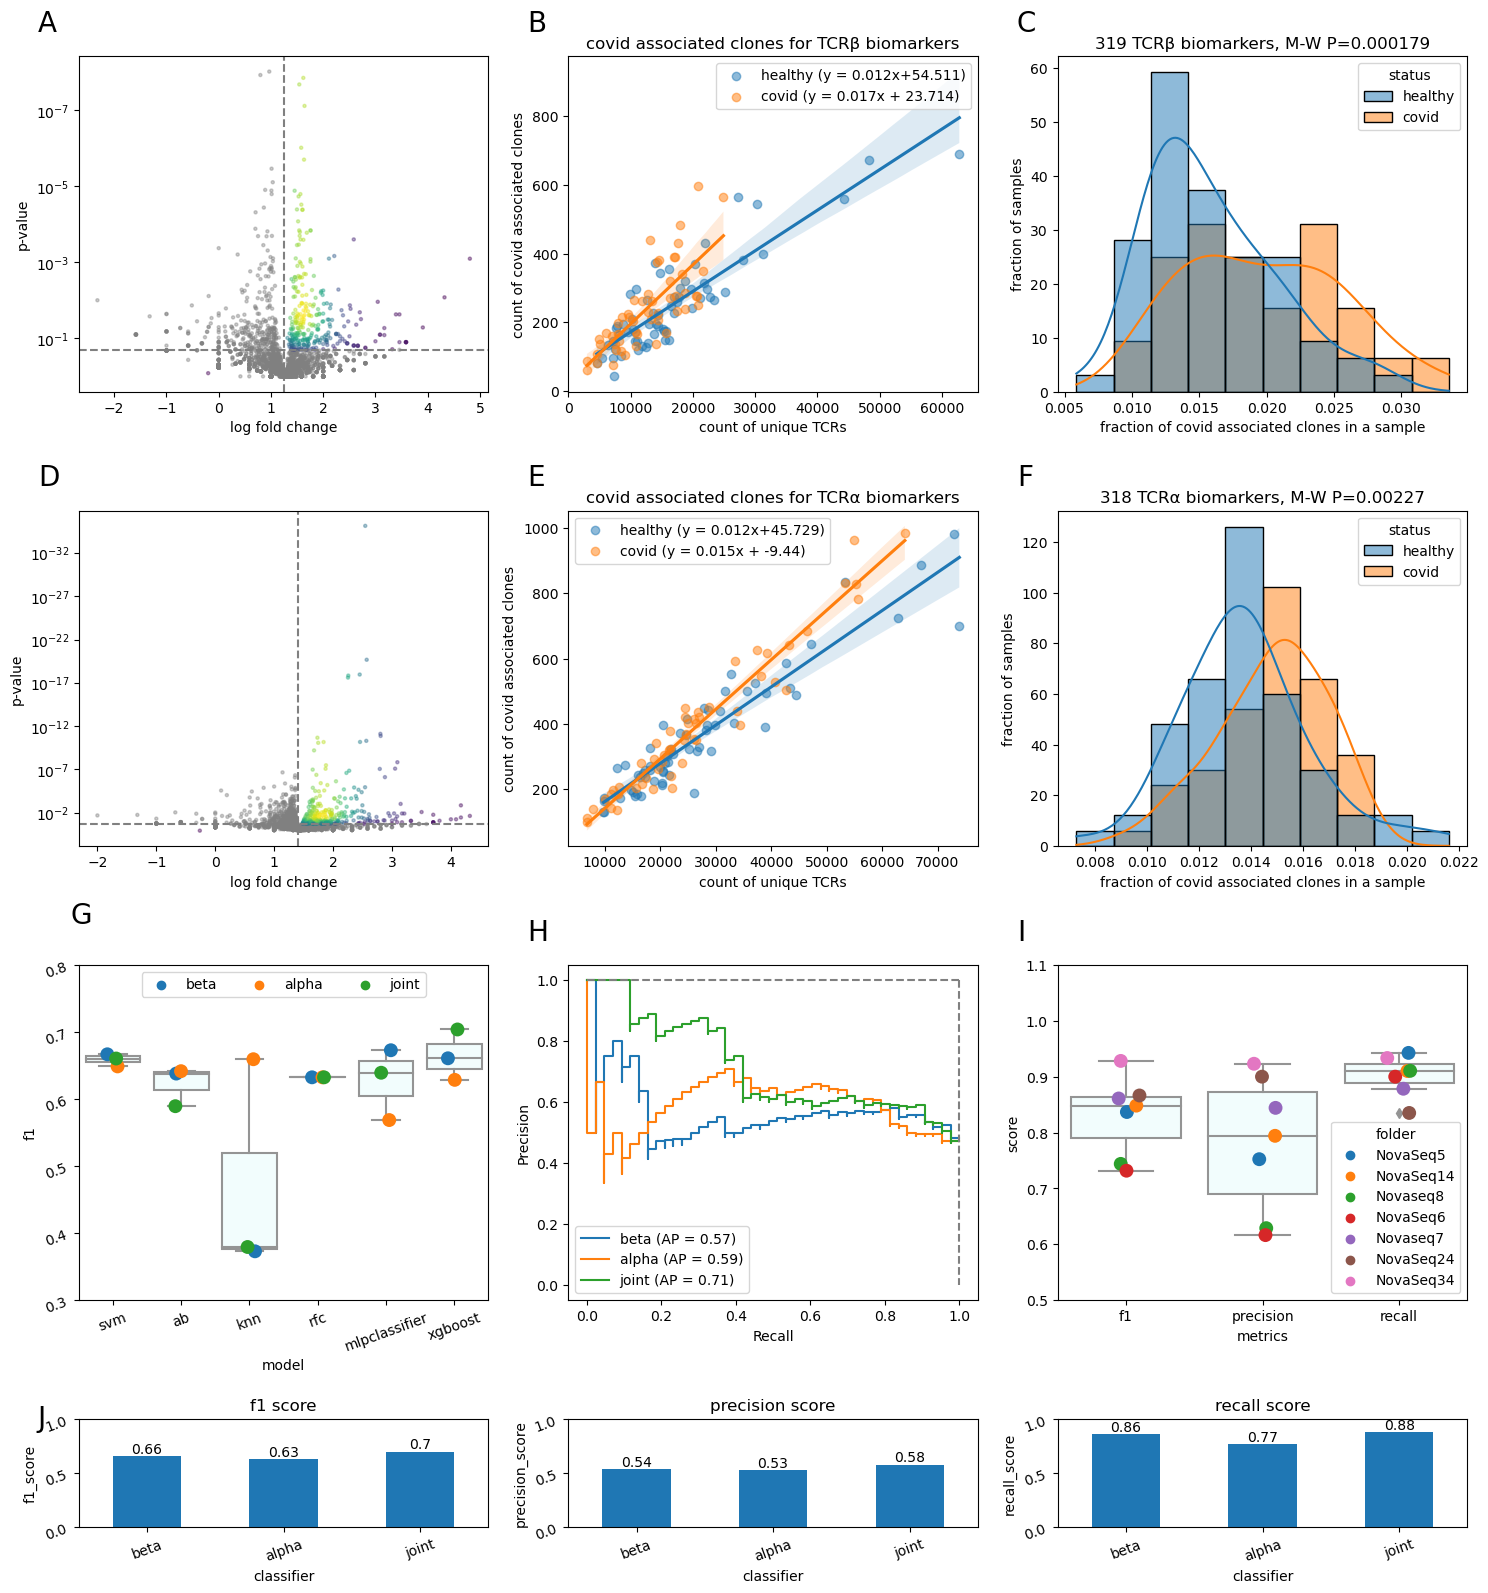

In [279]:
fig = plt.figure(figsize=(15, 20))
gs = GridSpec(nrows=9, 
              ncols=3)
font_size=20
delta_x=-0.1
delta_y=1.14

########################################################

ax0 = fig.add_subplot(gs[:2, 0])
plot_volcano(fold_change_vdjdb_beta, pval_threshold=0.2, fold_change_threshold=1.25, ax=ax0)

ax1 = fig.add_subplot(gs[:2, 1])
ax2 = fig.add_subplot(gs[:2, 2])

significant_clones_distribution(significant_clonotype_matrix=beta_cm_selected[beta_cm_selected.run.isin(test_runs)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                reg_ax=ax1, hist_ax=ax2)

ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax2.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

########################################################

ax3 = fig.add_subplot(gs[2:4, 0])
plot_volcano(fold_change_vdjdb_alpha, pval_threshold=0.2, fold_change_threshold=1.4, ax=ax3)

ax4 = fig.add_subplot(gs[2:4, 1])
ax5 = fig.add_subplot(gs[2:4, 2])

significant_clones_distribution(significant_clonotype_matrix=alpha_cm_selected[alpha_cm_selected.run.isin(test_runs)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'), 
                                desc=desc, 
                                data_description='TCRα biomarkers',
                                by='covid',
                                reg_ax=ax4, hist_ax=ax5)

ax3.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)
ax4.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)
ax5.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)

########################################################

for i, (letter, metrics) in enumerate(zip(['J', None, None], ['f1_score', 'precision_score', 'recall_score'])):
    
    ax = fig.add_subplot(gs[6, i])
    plotting_df[['classifier', metrics]].set_index('classifier').plot(kind='bar', ax=ax)
    ax.bar_label(ax.containers[0])
    ax.tick_params(labelrotation=20)
    ax.get_legend().remove()
    ax.set_ylabel(metrics)
    ax.set_title(f"{metrics.replace('_', ' ')}")
    ax.tick_params(labelrotation=20)
    ax.set_ylim(0, 1)
    if letter is not None:
        ax.text(delta_x, delta_y, letter,
             horizontalalignment='left',
             verticalalignment='top',
            transform=ax.transAxes,
                size=font_size)

########################################################
ax6 = fig.add_subplot(gs[4:6, 1])

for key in all_clfs:
    PrecisionRecallDisplay.from_estimator(
        all_clfs[key][0][all_clfs[key][2]], X_test_data[key], y_test_data[key], name=key, ax=ax6
    )
    # fpr, tpr, _ = roc_curve(y_test_data[key], all_clfs[key][0][all_clfs[key][2]].predict_proba(X_test_data[key])[::,1])
    # ax3.plot(fpr,tpr, label=key)

ax6.set_ylabel('Precision')
ax6.set_xlabel('Recall')
ax6.plot([0, 1], [1, 1], linestyle='dashed', color='grey')
ax6.plot([1, 1], [1, 0], linestyle='dashed', color='grey')
ax6.legend()
# ax3.set_title('ROC-curve')
ax6.text(delta_x, delta_y, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)

########################################################
ax7 = fig.add_subplot(gs[4:6, 2])

sns.stripplot(data=metrics_df, x="metrics", y="score", hue="folder", s=10, ax=ax7)
sns.boxplot(data=metrics_df, x="metrics", y="score", color='azure', ax=ax7)
# ax7.set_title('Scores across batches for α+β metaclone classifier')
ax7.set_ylim(0.5, 1.1)
ax7.text(delta_x, delta_y, 'I',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)

########################################################

ax9 = fig.add_subplot(gs[4:6, 0])
sns.stripplot(data=comparison_df, x="model", y="f1", hue="data_type", ax=ax9, s=10)
sns.boxplot(data=comparison_df, x="model", y="f1", ax=ax9, color='azure')
ax9.text(delta_x+0.08, delta_y+0.05, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax9.transAxes,
        size=font_size)
# ax9.set_title('Comparison of f1-score across models')
ax9.tick_params(labelrotation=20)
ax9.set_ylim(0.3, 0.8)
ax9.legend(ncol=3,  loc='upper center')

########################################################

plt.tight_layout()
plt.savefig("figures/supp_fig3.svg")
plt.savefig("figures/supp_fig3.pdf")
plt.savefig("figures/supp_fig3.png")
plt.show()


Figure 4. Analysis of machine learning approaches applied to FMBA TCRβ and TCRα biomarkers. 

A, B, C. Distribution of target metrics (f1-score, precision, recall) for all the evaluated models.

D. ROC-curve plot for all the evaluated models.

E. The sctterplot describing the relation of the probabilities to label the sample as the COVID-19 positive for TRCα and TCRβ based classifiers.

F. The sctterplot describing the relation of the probabilities to label the sample as the COVID-19 positive for classifier based on both TRCα,TCRβ biomarkers and TRCα,TCRβ metaclone cluster features.

G. The waterfall plot representing the probability of each sample to be labeld as COVID-19 positiove (> 0) or healthy (< 0). Samples coming from healthy donors are colored with blue, COVID-19 samples are colored with orange.

H. Evaluation of target metrics (f1-score, precision, recall) for one batch out cross validation.

I. Feature importance plot for the XGBoost classifier based on TRCα and TCRβ based biomarkers and HLA presence features.